In [ ]:
# 📦 INSTALLATION & SETUP
# IMPORTANT: Enable GPU in Colab (Runtime → Change runtime type → T4 GPU)

!pip install feedparser tiktoken sentence-transformers chromadb langchain langchain-community datasets transformers torch matplotlib pandas seaborn scikit-learn accelerate -q

# Import all libraries
import feedparser
import tiktoken
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.utils import embedding_functions
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.schema import Document
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import torch
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ All packages installed successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🎯 CUDA available: {torch.cuda.is_available()}")

# Check GPU status
if not torch.cuda.is_available():
    print("\n" + "="*80)
    print("⚠️  WARNING: GPU NOT ENABLED - TRAINING WILL BE VERY SLOW!")
    print("="*80)
    print("\n🔧 HOW TO ENABLE T4 GPU:")
    print("   1. Click 'Runtime' in top menu")
    print("   2. Click 'Change runtime type'")
    print("   3. Select 'T4 GPU' from Hardware accelerator")
    print("   4. Click 'Save' and re-run this cell")
    print("\n⏱️  WITHOUT GPU: 2-4 hours | WITH GPU: 15-20 minutes")
    print("="*80)
else:
    print(f"\n✅ GPU ENABLED: {torch.cuda.get_device_name(0)}")
    print("🚀 Training will be fast!")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#Seteando IA para Task 2:

#NEWS RETRIEVAL SYSTEM FROM RPP RSS FEED
print("🔄 Fetching news from RPP Perú RSS feed...")

# Parse the RSS feed
rss_url = "https://rpp.pe/rss"
feed = feedparser.parse(rss_url)

# Extract 50 latest news items
news_data = []
for entry in feed.entries[:50]:
    news_item = {
        'title': entry.get('title', ''),
        'description': entry.get('summary', ''),
        'link': entry.get('link', ''),
        'published': entry.get('published', '')
    }
    news_data.append(news_item)

# Convert to DataFrame
df_rpp = pd.DataFrame(news_data)

print(f"✅ Successfully loaded {len(df_rpp)} news articles from RPP")
print(f"\nColumns: {list(df_rpp.columns)}")
print(f"\n📊 First 3 articles:")
df_rpp.head(3)

🔄 Fetching news from RPP Perú RSS feed...
✅ Successfully loaded 50 news articles from RPP

Columns: ['title', 'description', 'link', 'published']

📊 First 3 articles:


,title,description,link,published
0,Tabla de posiciones de Liga 1 Te Apuesto 2025 ...,Sigue el movimiento de las posiciones y cómo v...,https://rpp.pe/futbol/descentralizado/tabla-ac...,"Thu, 23 Oct 2025 22:10:26 -0500"
1,Cusco: niña de tres años sufre grave lesión en...,"La menor, tras ser sometida a la cirugía, fue ...",https://rpp.pe/peru/actualidad/cusco-nina-de-t...,"Thu, 23 Oct 2025 22:02:55 -0500"
2,¡Con sabor a 'tri'! Universitario venció 1-0 a...,Alex Valera le dio la victoria a Universitario...,https://rpp.pe/futbol/descentralizado/universi...,"Thu, 23 Oct 2025 22:00:08 -0500"


In [ ]:
# 1️⃣ TOKENIZATION
print("🔤 Tokenizing sample article...")

# Initialize tiktoken encoder
encoding = tiktoken.get_encoding("cl100k_base")

# Take a sample article
sample_text = df_rpp.iloc[0]['title'] + " " + df_rpp.iloc[0]['description']

# Tokenize
tokens = encoding.encode(sample_text)
num_tokens = len(tokens)

print(f"\n📝 Sample Article:")
print(f"Title: {df_rpp.iloc[0]['title']}")
print(f"\nDescription: {df_rpp.iloc[0]['description'][:200]}...")
print(f"\n🔢 Token count: {num_tokens}")

# Check if chunking is needed
context_limit = 512
if num_tokens > context_limit:
    print(f"⚠️  Text exceeds {context_limit} tokens - chunking recommended")
else:
    print(f"✅ Text fits within {context_limit} token limit")

# Calculate tokens for all articles
df_rpp['full_text'] = df_rpp['title'] + " " + df_rpp['description']
df_rpp['num_tokens'] = df_rpp['full_text'].apply(lambda x: len(encoding.encode(x)))

print(f"\n📊 Token Statistics:")
print(f"Mean tokens: {df_rpp['num_tokens'].mean():.2f}")
print(f"Max tokens: {df_rpp['num_tokens'].max()}")
print(f"Min tokens: {df_rpp['num_tokens'].min()}")

🔤 Tokenizing sample article...

📝 Sample Article:
Title: Tabla de posiciones de Liga 1 Te Apuesto 2025 EN VIVO: Acumulado y resultados tras la victoria de Universitario

Description: Sigue el movimiento de las posiciones y cómo va la Tabla Acumulada de la Liga1 Te Apuesto 2025. Universitario derrotó a Sporting Cristal y quedó cerca de llevarse el Clausura....

🔢 Token count: 81
✅ Text fits within 512 token limit

📊 Token Statistics:
Mean tokens: 83.84
Max tokens: 129
Min tokens: 55


In [ ]:
# 2️⃣ EMBEDDING
print("🧬 Generating embeddings using SentenceTransformers...")

# Load the embedding model
model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedding_model = SentenceTransformer(model_name)

print(f"✅ Loaded model: {model_name}")
print(f"📐 Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")

# Generate embeddings for all articles
texts_to_embed = df_rpp['full_text'].tolist()
embeddings = embedding_model.encode(texts_to_embed, show_progress_bar=True)

print(f"\n✅ Generated {len(embeddings)} embeddings")
print(f"📊 Embedding shape: {embeddings.shape}")

# Add embeddings to dataframe
df_rpp['embedding'] = list(embeddings)

🧬 Generating embeddings using SentenceTransformers...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Loaded model: sentence-transformers/all-MiniLM-L6-v2
📐 Embedding dimension: 384


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


✅ Generated 50 embeddings
📊 Embedding shape: (50, 384)


In [ ]:
# 3️⃣ CREATE CHROMADB COLLECTION
print("💾 Creating ChromaDB collection...")

# Initialize ChromaDB client
chroma_client = chromadb.Client()

# Create or get collection
collection_name = "rpp_news_collection"

# Delete collection if exists
try:
    chroma_client.delete_collection(name=collection_name)
    print("🗑️  Deleted existing collection")
except:
    pass

# Create new collection
sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name=model_name
)

collection = chroma_client.create_collection(
    name=collection_name,
    embedding_function=sentence_transformer_ef
)

# Prepare documents for ChromaDB
documents = df_rpp['full_text'].tolist()
metadatas = [
    {
        'title': row['title'],
        'link': row['link'],
        'published': row['published']
    }
    for _, row in df_rpp.iterrows()
]
ids = [f"doc_{i}" for i in range(len(df_rpp))]

# Add documents to collection
collection.add(
    documents=documents,
    metadatas=metadatas,
    ids=ids
)

print(f"✅ Collection '{collection_name}' created successfully")
print(f"📊 Total documents in collection: {collection.count()}")

💾 Creating ChromaDB collection...
✅ Collection 'rpp_news_collection' created successfully
📊 Total documents in collection: 50


In [ ]:
# 4️⃣ QUERY RESULTS
print("🔍 Querying the collection...")

# Query with Spanish economic news
query = "Últimas noticias de economía"
print(f"\n📝 Query: '{query}'")

# Perform similarity search
results = collection.query(
    query_texts=[query],
    n_results=5
)

# Format results as DataFrame
retrieved_docs = []
for i in range(len(results['ids'][0])):
    doc = {
        'title': results['metadatas'][0][i]['title'],
        'description': results['documents'][0][i],
        'link': results['metadatas'][0][i]['link'],
        'date_published': results['metadatas'][0][i]['published']
    }
    retrieved_docs.append(doc)

df_results = pd.DataFrame(retrieved_docs)

print(f"\n✅ Found {len(df_results)} relevant articles\n")
print("="*80)
for idx, row in df_results.iterrows():
    print(f"\n🔹 Result {idx + 1}:")
    print(f"Title: {row['title']}")
    print(f"Published: {row['date_published']}")
    print(f"Link: {row['link']}")
    print("-"*80)

df_results

🔍 Querying the collection...

📝 Query: 'Últimas noticias de economía'

✅ Found 5 relevant articles


🔹 Result 1:
Title: MEF y el presidente Jerí revisan el Presupuesto Público 2026: “Cada sol invertido debe traducirse en bienestar”
Published: Thu, 23 Oct 2025 19:18:25 -0500
Link: https://rpp.pe/economia/economia/mef-y-el-presidente-jeri-revisan-el-presupuesto-publico-2026-cada-sol-invertido-debe-traducirse-en-bienestar-noticia-1660716
--------------------------------------------------------------------------------

🔹 Result 2:
Title: La Libertad: detienen a excabo del Ejército acusado de minería ilegal en Pataz
Published: Thu, 23 Oct 2025 21:55:58 -0500
Link: https://rpp.pe/peru/actualidad/la-libertad-detienen-a-excabo-del-ejercito-por-mineria-ilegal-en-pataz-noticia-1660733
--------------------------------------------------------------------------------

🔹 Result 3:
Title: Congreso elimina sesiones virtuales a partir de julio del 2026
Published: Thu, 23 Oct 2025 20:26:11 -0500
Link: h

,title,description,link,date_published
0,MEF y el presidente Jerí revisan el Presupuest...,MEF y el presidente Jerí revisan el Presupuest...,https://rpp.pe/economia/economia/mef-y-el-pres...,"Thu, 23 Oct 2025 19:18:25 -0500"
1,La Libertad: detienen a excabo del Ejército ac...,La Libertad: detienen a excabo del Ejército ac...,https://rpp.pe/peru/actualidad/la-libertad-det...,"Thu, 23 Oct 2025 21:55:58 -0500"
2,Congreso elimina sesiones virtuales a partir d...,Congreso elimina sesiones virtuales a partir d...,https://rpp.pe/politica/congreso/congreso-elim...,"Thu, 23 Oct 2025 20:26:11 -0500"
3,"Tras cambio en el reglamento del Congreso, arc...","Tras cambio en el reglamento del Congreso, arc...",https://rpp.pe/politica/elecciones/tras-cambio...,"Thu, 23 Oct 2025 19:49:41 -0500"
4,Fiscalía insiste en su pedido para que se orde...,Fiscalía insiste en su pedido para que se orde...,https://rpp.pe/politica/judiciales/dina-boluar...,"Thu, 23 Oct 2025 18:41:31 -0500"


In [ ]:
# 5️⃣ LANGCHAIN ORCHESTRATION
print("🔗 Building end-to-end LangChain pipeline...")

from langchain_community.embeddings import HuggingFaceEmbeddings

# Step 1: Load RSS function
def load_rss_feed(url, max_items=50):
    feed = feedparser.parse(url)
    documents = []
    for entry in feed.entries[:max_items]:
        doc = Document(
            page_content=f"{entry.get('title', '')} {entry.get('summary', '')}",
            metadata={
                'title': entry.get('title', ''),
                'link': entry.get('link', ''),
                'published': entry.get('published', '')
            }
        )
        documents.append(doc)
    return documents

# Step 2: Initialize embedding function
embeddings = HuggingFaceEmbeddings(model_name=model_name)

# Step 3: Create vector store
print("\n1️⃣ Loading RSS feed...")
documents = load_rss_feed(rss_url, max_items=50)
print(f"   ✅ Loaded {len(documents)} documents")

print("\n2️⃣ Creating embeddings...")
vectorstore = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    collection_name="langchain_rpp_news"
)
print(f"   ✅ Vector store created")

# Step 4: Create retriever
print("\n3️⃣ Creating retriever...")
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
print(f"   ✅ Retriever ready")

# Step 5: Query
print("\n4️⃣ Querying...")
query = "noticias sobre tecnología e inteligencia artificial"
retrieved_docs = retriever.get_relevant_documents(query)

print(f"\n🔍 Query: '{query}'")
print(f"✅ Retrieved {len(retrieved_docs)} documents\n")
print("="*80)

for i, doc in enumerate(retrieved_docs):
    print(f"\n🔹 Document {i+1}:")
    print(f"Title: {doc.metadata['title']}")
    print(f"Published: {doc.metadata['published']}")
    print(f"Link: {doc.metadata['link']}")
    print("-"*80)

print("\n✅ LangChain pipeline completed successfully!")

🔗 Building end-to-end LangChain pipeline...

1️⃣ Loading RSS feed...
   ✅ Loaded 50 documents

2️⃣ Creating embeddings...
   ✅ Vector store created

3️⃣ Creating retriever...
   ✅ Retriever ready

4️⃣ Querying...

🔍 Query: 'noticias sobre tecnología e inteligencia artificial'
✅ Retrieved 5 documents


🔹 Document 1:
Title: Roberto Burneo: JNE definirá si se utilizará o no el voto digital en las Elecciones 2026 tras proceso de auditoría
Published: Thu, 23 Oct 2025 21:03:17 -0500
Link: https://rpp.pe/politica/elecciones/roberto-burneo-jne-definira-si-se-utilizara-o-no-el-voto-digital-en-las-elecciones-2026-tras-proceso-de-auditoria-noticia-1660669
--------------------------------------------------------------------------------

🔹 Document 2:
Title: MEF y el presidente Jerí revisan el Presupuesto Público 2026: “Cada sol invertido debe traducirse en bienestar”
Published: Thu, 23 Oct 2025 19:18:25 -0500
Link: https://rpp.pe/economia/economia/mef-y-el-presidente-jeri-revisan-el-presupuesto-pu

In [ ]:
# TASK 2: TRANSFORMER NEWS CLASSIFICATION (AG NEWS)
print("📚 Loading AG News dataset...")

# Load dataset
dataset = load_dataset("ag_news")

print(f"\n✅ Dataset loaded successfully!")
print(f"\n📊 Dataset structure:")
print(dataset)

# Show categories
categories = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Science/Technology"
}

print(f"\n🏷️  Categories:")
for idx, cat in categories.items():
    print(f"  {idx} - {cat}")

# Display sample
print(f"\n📝 Sample article:")
sample = dataset['train'][0]
print(f"Label: {sample['label']} ({categories[sample['label']]})")
print(f"Text: {sample['text'][:200]}...")

# Show dataset sizes
print(f"\n📊 Original split sizes:")
print(f"Train: {len(dataset['train'])} samples")
print(f"Test: {len(dataset['test'])} samples")

📚 Loading AG News dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]


✅ Dataset loaded successfully!

📊 Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

🏷️  Categories:
  0 - World
  1 - Sports
  2 - Business
  3 - Science/Technology

📝 Sample article:
Label: 2 (Business)
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again....

📊 Original split sizes:
Train: 120000 samples
Test: 7600 samples


In [ ]:
# Split dataset into 70% train, 15% validation, 15% test
print("✂️ Splitting dataset into train/validation/test...")

from datasets import Dataset, DatasetDict

# Use original train set and split it
original_train = dataset['train']

# Calculate split sizes
train_val_split = original_train.train_test_split(test_size=0.176, seed=42)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

# Use original test
test_dataset = dataset['test']

print(f"\n✅ Dataset split completed!")
print(f"\n📊 Original split sizes:")
print(f"  🎯 Training: {len(train_dataset)} samples")
print(f"  🔍 Validation: {len(val_dataset)} samples")
print(f"  🔒 Test (LOCKED): {len(test_dataset)} samples")

# 🚀 SPEED OPTIMIZATION: Use subset for faster training
USE_SUBSET = True  # Set to False to use full dataset (will take 8+ hours!)

if USE_SUBSET:
    print(f"\n⚡ Using subset for FAST training...")
    train_dataset = train_dataset.select(range(min(10000, len(train_dataset))))
    val_dataset = val_dataset.select(range(min(2000, len(val_dataset))))
    print(f"  • Training subset: {len(train_dataset)} samples")
    print(f"  • Validation subset: {len(val_dataset)} samples")
    print(f"  • Estimated time: ~15-20 minutes with GPU ⚡")
else:
    print(f"\n⚠️  Using FULL dataset - will take 6-8 hours!")

print(f"\n⚠️  Test set will NOT be used until final evaluation!")

# Create new dataset dict
split_dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(f"\n📦 Dataset ready for training!")

✂️ Splitting dataset into train/validation/test...

✅ Dataset split completed!

📊 Original split sizes:
  🎯 Training: 98880 samples
  🔍 Validation: 21120 samples
  🔒 Test (LOCKED): 7600 samples

⚡ Using subset for FAST training...
  • Training subset: 10000 samples
  • Validation subset: 2000 samples
  • Estimated time: ~15-20 minutes with GPU ⚡

⚠️  Test set will NOT be used until final evaluation!

📦 Dataset ready for training!


In [ ]:
# 2️⃣ MODEL TRAINING
print("🤖 Preparing models for training...")

# Select model (change to "microsoft/deberta-v3-base" if desired)
model_name = "roberta-base"

print(f"\n🎯 Selected model: {model_name}")

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=4,
    id2label={0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"},
    label2id={"World": 0, "Sports": 1, "Business": 2, "Sci/Tech": 3}
)

print(f"✅ Model and tokenizer loaded successfully!")
print(f"⚠️  Warning about 'classifier' layers is NORMAL - they'll be trained next")

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

print(f"\n🔤 Tokenizing datasets...")
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

print(f"✅ Tokenization completed!")

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print(f"\n📦 Ready to start training!")

🤖 Preparing models for training...

🎯 Selected model: roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model and tokenizer loaded successfully!
⚠️  Warning about 'classifier' layers is NORMAL - they'll be trained next

🔤 Tokenizing datasets...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

✅ Tokenization completed!

📦 Ready to start training!


In [ ]:
# Configure training arguments
print("🏋️ Configuring training parameters...")

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=100,
    save_total_limit=2,
    seed=42
)

print(f"✅ Training configuration set!")
print(f"\n⚙️  Training parameters:")
print(f"  • Learning rate: {training_args.learning_rate}")
print(f"  • Batch size: {training_args.per_device_train_batch_size}")
print(f"  • Epochs: {training_args.num_train_epochs}")
print(f"  • Device: {'GPU ✅' if torch.cuda.is_available() else 'CPU ⚠️'}")

# Define compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')

    return {
        'f1': f1_macro,
        'f1_weighted': f1_weighted
    }

print(f"\n✅ Metrics function defined (F1-score macro and weighted)")

🏋️ Configuring training parameters...
✅ Training configuration set!

⚙️  Training parameters:
  • Learning rate: 2e-05
  • Batch size: 16
  • Epochs: 3
  • Device: GPU ✅

✅ Metrics function defined (F1-score macro and weighted)


In [ ]:
# Initialize Trainer
print("🚀 Initializing Trainer...")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print(f"\n✅ Trainer initialized!")
print(f"\n🏃 Starting training...")
print(f"⏱️  Estimated time: ~15-20 minutes with GPU")
print("="*80)

# Train the model
train_result = trainer.train()

print("\n" + "="*80)
print(f"\n✅ Training completed!")
print(f"\n📊 Training summary:")
print(f"  • Total training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"  • Training loss: {train_result.metrics['train_loss']:.4f}")

# Evaluate on validation set
print(f"\n🔍 Evaluating on validation set...")
val_results = trainer.evaluate()

print(f"\n📊 Validation Results:")
print(f"  • Validation Loss: {val_results['eval_loss']:.4f}")
print(f"  • F1 Score (macro): {val_results['eval_f1']:.4f}")
print(f"  • F1 Score (weighted): {val_results['eval_f1_weighted']:.4f}")

# Save the model
print(f"\n💾 Saving model...")
trainer.save_model("./best_model")
print(f"✅ Model saved to './best_model'")

🚀 Initializing Trainer...

✅ Trainer initialized!

🏃 Starting training...
⏱️  Estimated time: ~15-20 minutes with GPU


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da-chumacerop (da-chumacerop-universidad-del-pacifico) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [langchain] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Epoch,Training Loss,Validation Loss,F1,F1 Weighted
1,0.294000,0.313961,0.914995,0.915579
2,0.216700,0.323617,0.908480,0.909142
3,0.149500,0.321882,0.921511,0.921965




✅ Training completed!

📊 Training summary:
  • Total training time: 3104.34 seconds
  • Training loss: 0.2477

🔍 Evaluating on validation set...



📊 Validation Results:
  • Validation Loss: 0.3219
  • F1 Score (macro): 0.9215
  • F1 Score (weighted): 0.9220

💾 Saving model...
✅ Model saved to './best_model'


In [ ]:
# 3️⃣ FINAL EVALUATION ON TEST SET (ONLY ONCE!)
print("🔒 Final Evaluation on Test Set")
print("="*80)
print("⚠️  This is the ONLY time we touch the test set!\n")

# Evaluate on test set
test_results = trainer.evaluate(tokenized_test)

print(f"\n🎯 TEST SET RESULTS:")
print(f"  • Test Loss: {test_results['eval_loss']:.4f}")
print(f"  • F1 Score (macro): {test_results['eval_f1']:.4f}")
print(f"  • F1 Score (weighted): {test_results['eval_f1_weighted']:.4f}")

# Get predictions for detailed analysis
predictions = trainer.predict(tokenized_test)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Generate classification report
print(f"\n📊 Detailed Classification Report:")
print("-"*80)
print(classification_report(
    true_labels,
    pred_labels,
    target_names=list(categories.values()),
    digits=4
))

# Store results for comparison
results_dict = {
    'model': model_name,
    'f1_macro': test_results['eval_f1'],
    'f1_weighted': test_results['eval_f1_weighted'],
    'test_loss': test_results['eval_loss']
}

print(f"\n✅ Final evaluation completed!")

🔒 Final Evaluation on Test Set
⚠️  This is the ONLY time we touch the test set!




🎯 TEST SET RESULTS:
  • Test Loss: 0.2953
  • F1 Score (macro): 0.9270
  • F1 Score (weighted): 0.9270

📊 Detailed Classification Report:
--------------------------------------------------------------------------------
                    precision    recall  f1-score   support

             World     0.9425    0.9142    0.9281      1900
            Sports     0.9665    0.9874    0.9768      1900
          Business     0.8922    0.9021    0.8971      1900
Science/Technology     0.9071    0.9047    0.9059      1900

          accuracy                         0.9271      7600
         macro avg     0.9271    0.9271    0.9270      7600
      weighted avg     0.9271    0.9271    0.9270      7600


✅ Final evaluation completed!


📊 Creating visualizations...


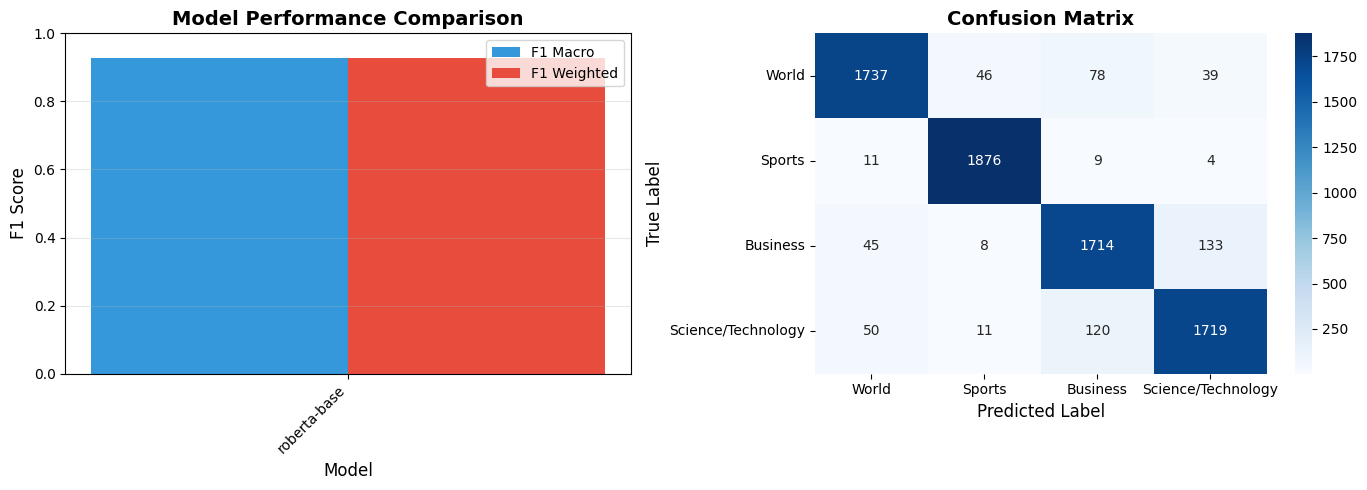


✅ Visualizations created and saved!

📈 Performance Summary:
  • Model: roberta-base
  • F1 Score (macro): 0.9270
  • F1 Score (weighted): 0.9270


In [ ]:
# 4️⃣ VISUALIZATION
print("📊 Creating visualizations...")

from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: F1 Scores
model_names = [model_name.split('/')[-1]]
f1_scores = [results_dict['f1_macro']]
f1_weighted_scores = [results_dict['f1_weighted']]

x = np.arange(len(model_names))
width = 0.35

axes[0].bar(x - width/2, f1_scores, width, label='F1 Macro', color='#3498db')
axes[0].bar(x + width/2, f1_weighted_scores, width, label='F1 Weighted', color='#e74c3c')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Plot 2: Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories.values(),
            yticklabels=categories.values(),
            ax=axes[1])
axes[1].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualizations created and saved!")
print(f"\n📈 Performance Summary:")
print(f"  • Model: {model_name}")
print(f"  • F1 Score (macro): {results_dict['f1_macro']:.4f}")
print(f"  • F1 Score (weighted): {results_dict['f1_weighted']:.4f}")

🎁 BONUS: Classifying RPP news with trained model

📰 Classifying 10 RPP news articles...

🎯 Classification Results:


📰 Article 1:
Title: Tabla de posiciones de Liga 1 Te Apuesto 2025 EN VIVO: Acumulado y resultados tr...
Predicted Category: Sports
Link: https://rpp.pe/futbol/descentralizado/tabla-acumulada-liga-1-y-torneo-clausura-2025-en-vivo-resultados-y-posiciones-tras-partidos-de-hoy-universitario-alianza-lima-sporting-cristal-noticia-1647030
--------------------------------------------------------------------------------

📰 Article 2:
Title: Cusco: niña de tres años sufre grave lesión en las piernas tras ser atropellada ...
Predicted Category: Science/Technology
Link: https://rpp.pe/peru/actualidad/cusco-nina-de-tres-anos-sufre-grave-lesion-en-las-piernas-tras-ser-atropellada-por-un-bus-noticia-1660734
--------------------------------------------------------------------------------

📰 Article 3:
Title: ¡Con sabor a 'tri'! Universitario venció 1-0 a Sporting Cristal y quedó a un pa

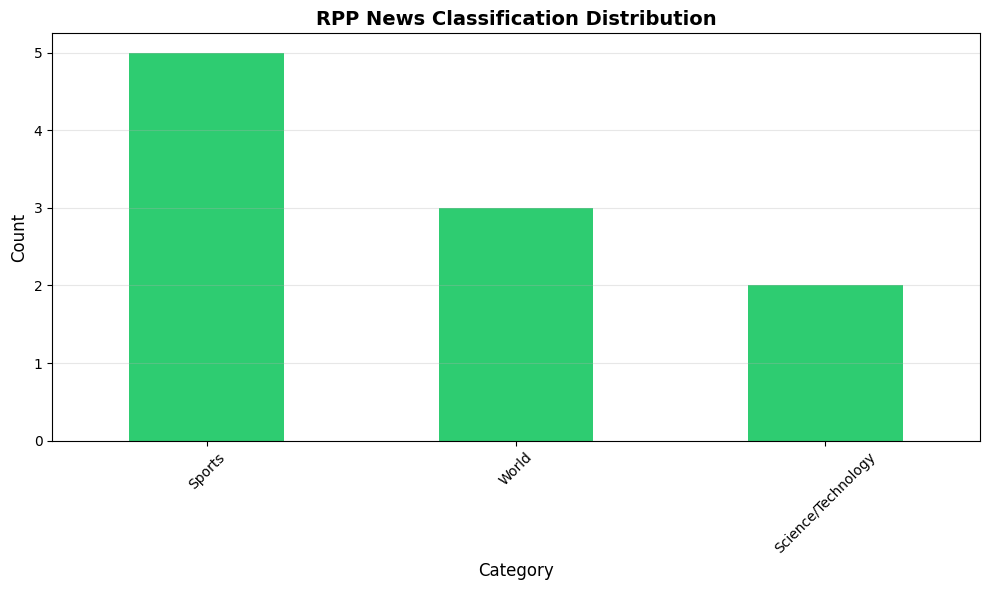


✅ Bonus task completed!

💡 Note: To complete the full bonus:
  1. Use OpenAI API or another LLM to classify these articles
  2. Compare LLM vs model classifications
  3. Calculate F1 scores and analyze discrepancies


In [ ]:
# 🎁 BONUS TASK - RPP NEWS CLASSIFICATION
print("🎁 BONUS: Classifying RPP news with trained model")
print("="*80)

# Take first 10 RPP articles
rpp_sample = df_rpp.head(10)

print(f"\n📰 Classifying {len(rpp_sample)} RPP news articles...\n")

# Prepare texts
rpp_texts = rpp_sample['full_text'].tolist()

# Tokenize
rpp_tokenized = tokenizer(
    rpp_texts,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
rpp_tokenized = {k: v.to(device) for k, v in rpp_tokenized.items()}

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(**rpp_tokenized)
    predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

# Add predictions
rpp_sample_copy = rpp_sample.copy()
rpp_sample_copy['predicted_category'] = [categories[p] for p in predictions]

# Display results
print("🎯 Classification Results:\n")
print("="*80)
for idx, row in rpp_sample_copy.iterrows():
    print(f"\n📰 Article {idx + 1}:")
    print(f"Title: {row['title'][:80]}...")
    print(f"Predicted Category: {row['predicted_category']}")
    print(f"Link: {row['link']}")
    print("-"*80)

# Show distribution
category_counts = rpp_sample_copy['predicted_category'].value_counts()
print(f"\n📊 Category Distribution:")
print(category_counts)

# Visualization
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='#2ecc71')
plt.title('RPP News Classification Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('rpp_classification.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Bonus task completed!")
print(f"\n💡 Note: To complete the full bonus:")
print(f"  1. Use OpenAI API or another LLM to classify these articles")
print(f"  2. Compare LLM vs model classifications")
print(f"  3. Calculate F1 scores and analyze discrepancies")